## Intro to anomaly detection with OpenCV

I prepared this notebook while reading https://pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/ . Thanks to Adrian for this good intro about anomaly detection,codes and images. I will just follow the blog and may add some commends to code blocks.

Anomalies are defined as events that deviate from the standard, rarely happen, and don’t follow the rest of the “pattern”

These events will occur, but will happen with an incredibly small probability. From a machine learning perspective, this makes detecting anomalies hard — by definition, we have many examples of “standard” events and few examples of “anomaly” events.

Anomaly detection algorithms can be broken down into two subclasses:

 * Outlier detection: Our input dataset contains examples of both standard events and anomaly events. These algorithms seek to fit regions of the training data where the standard events are most concentrated, disregarding, and therefore isolating, the anomaly events.unsupervised fashion (i.e., without labels).
 
 * Novelty detection : novelty detection algorithms have only the standard event data points (i.e., no anomaly events) during training time. During training, we provide these algorithms with labeled examples of standard events (supervised learning).


we’ll be focusing on novelty detection as a form of anomaly detection.

We’ll be using Isolation Forests to perform anomaly detection, based on Liu et al.’s 2012 paper

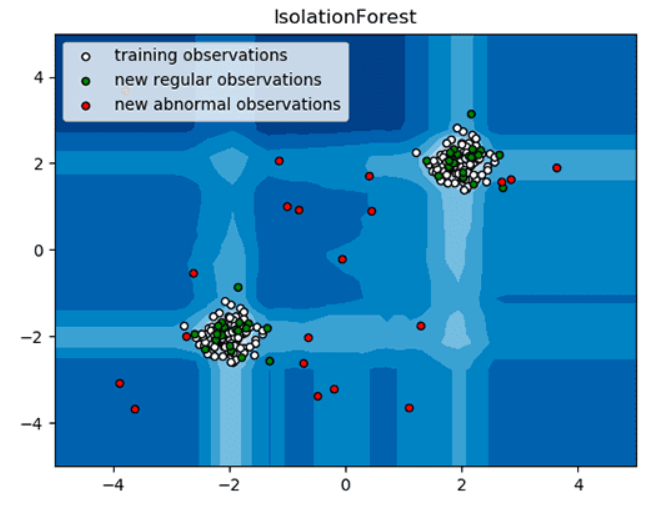

At test time, the Isolation Forest can then determine if the input points fall inside the manifold (standard events; green points) or outside the high-density area (anomaly events; red points).

We will train our model with 16 forest images and then test our model with different kind of images. our model must decide if a new input image fits inside the “forest manifold” or if is truly an anomaly/outlier.

If our anomaly detection pipeline is working properly, our model should return 1 (inlier) for the forest image and -1 non-forest image.

In [1]:
#from pyimagesearch.features import load_dataset
from sklearn.ensemble import IsolationForest
import argparse
import pickle
from imutils import paths
import imutils
import numpy as np
import cv2
from matplotlib import pyplot as plt

we must first define a process to quantify and characterize the contents of our input images. we’ll be using color histograms. Color histograms are simple yet effective methods to characterize the color distribution of an image. we may assume that forest images will contain more shades of green versus their non-forest counterparts.

OpenCV will be used to calculate and normalize histograms. Let's see what we will use, then combine them for creating a dataset

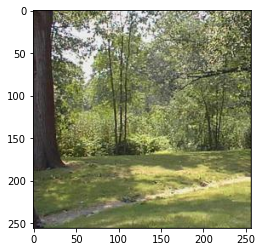

In [2]:
img_path='forest_example.jpg'
image = cv2.imread(img_path)
plt.imshow(imutils.opencv2matplotlib(image))
# show our plots
plt.show()


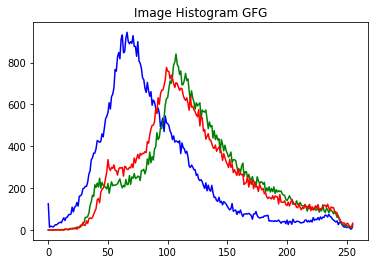

In [3]:
#if you want to see histogram

colors = ('b','g','r')
  
# compute and plot the image histograms
for i,color in enumerate(colors):
    hist = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(hist,color = color)
plt.title('Image Histogram GFG')
plt.show()

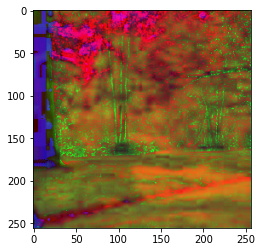

In [15]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(imutils.opencv2matplotlib(image))
# show our plots
plt.show()

In [16]:
hist = cv2.calcHist([image], [0, 1, 2], None, (4, 6, 3),[0, 180, 0, 256, 0, 256])

In [17]:
hist

array([[[9.7200e+02, 3.6410e+03, 2.4600e+03],
        [2.5000e+03, 1.3873e+04, 3.0750e+03],
        [2.9690e+03, 2.0769e+04, 3.7340e+03],
        [1.6660e+03, 2.7420e+03, 2.1600e+02],
        [5.0500e+02, 8.9000e+01, 0.0000e+00],
        [2.6700e+02, 4.0000e+00, 0.0000e+00]],

       [[1.6800e+02, 5.7000e+02, 5.7600e+02],
        [6.1000e+01, 1.0200e+02, 4.0000e+00],
        [2.0000e+01, 4.9000e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]],

       [[2.2200e+02, 3.3600e+02, 7.8300e+02],
        [3.2000e+01, 9.0000e+00, 0.0000e+00],
        [5.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]],

       [[2.0890e+03, 1.9500e+02, 2.8600e+02],
        [5.3400e+02, 1.0000e+00, 0.0000e+00],
        [1.1000e+01, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e

In [18]:
hist.shape

(4, 6, 3)

In [19]:
print("3D histogram shape: {}, with {} values".format(hist.shape, hist.flatten().shape[0]))

3D histogram shape: (4, 6, 3), with 72 values


In [21]:
len(hist.flatten())

72

After finding histogram, we will normalize it then flatten for training dataset

In [22]:
hist = cv2.normalize(hist, hist)

In [23]:
hist

array([[[3.6752578e-02, 1.3767092e-01, 9.3015783e-02],
        [9.4528235e-02, 5.2455604e-01, 1.1626972e-01],
        [1.1226173e-01, 7.8530276e-01, 1.4118737e-01],
        [6.2993616e-02, 1.0367856e-01, 8.1672389e-03],
        [1.9094704e-02, 3.3652051e-03, 0.0000000e+00],
        [1.0095615e-02, 1.5124517e-04, 0.0000000e+00]],

       [[6.3522970e-03, 2.1552436e-02, 2.1779304e-02],
        [2.3064888e-03, 3.8567518e-03, 1.5124517e-04],
        [7.5622584e-04, 1.8527533e-03, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[8.3941072e-03, 1.2704594e-02, 2.9606242e-02],
        [1.2099614e-03, 3.4030163e-04, 0.0000000e+00],
        [1.8905646e-04, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

    

In [24]:
flat_hist= hist.flatten()

In [25]:
flat_hist

array([3.6752578e-02, 1.3767092e-01, 9.3015783e-02, 9.4528235e-02,
       5.2455604e-01, 1.1626972e-01, 1.1226173e-01, 7.8530276e-01,
       1.4118737e-01, 6.2993616e-02, 1.0367856e-01, 8.1672389e-03,
       1.9094704e-02, 3.3652051e-03, 0.0000000e+00, 1.0095615e-02,
       1.5124517e-04, 0.0000000e+00, 6.3522970e-03, 2.1552436e-02,
       2.1779304e-02, 2.3064888e-03, 3.8567518e-03, 1.5124517e-04,
       7.5622584e-04, 1.8527533e-03, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.3941072e-03, 1.2704594e-02, 2.9606242e-02, 1.2099614e-03,
       3.4030163e-04, 0.0000000e+00, 1.8905646e-04, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 7.8987792e-02, 7.3732021e-03,
       1.0814030e-02, 2.0191230e-02, 3.7811293e-05, 0.0000000e

In [26]:
flat_hist.shape

(72,)

We need to do these steps for each training image and then fit our model with this dataset

In [27]:
datasetPath=r'C:\Users\Zeki\Desktop\kisisel calismalar\github_notebooks\AUTOENCODERS\pyimagesearch_blogs\forest'
imagePaths = list(paths.list_images(datasetPath))

In [28]:
imagePaths

['C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_bost100.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_bost101.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_bost102.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_bost103.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_bost98.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_cdmc458.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearch_blogs\\forest\\forest_for119.jpg',
 'C:\\Users\\Zeki\\Desktop\\kisisel calismalar\\github_notebooks\\AUTOENCODERS\\pyimagesearc

In [29]:
data = []

# loop over the image paths
for imagePath in imagePaths:
# load the image and convert it to the HSV color space
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], None, (3,3,3),[0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    data.append(hist)



In [33]:
data=np.array(data)

In [35]:
data.shape

(16, 27)

We create our dataset, now fit our model

In [36]:
# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
model = IsolationForest(n_estimators=100, contamination=0.01,random_state=42)
model.fit(data)

[INFO] fitting anomaly detection model...


IsolationForest(contamination=0.01, random_state=42)

In [39]:
# serialize the anomaly detection model to disk
f = open('Isolation_forest', "wb")
f.write(pickle.dumps(model))
f.close()

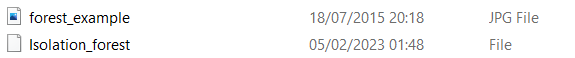

Now test our model for anomaly detection

First load model, then feature extraction with same parameter of dataset preperation and then .predict() for result

If it is normal, model will predict 1, otherwise it will be -1

In [40]:
# load the anomaly detection model
print("[INFO] loading anomaly detection model...")
model = pickle.loads(open('Isolation_forest', "rb").read())

[INFO] loading anomaly detection model...


In [50]:
image = cv2.imread('highway_test.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hist = cv2.calcHist([hsv], [0, 1, 2], None, (3,3,3),[0, 180, 0, 256, 0, 256])
hist = cv2.normalize(hist, hist).flatten()

In [51]:
preds = model.predict([hist])

In [52]:
preds

array([-1])

In [53]:

label = "anomaly" if preds == -1 else "normal"
print(label)

anomaly


In [54]:
color = (0, 0, 255) if preds == -1 else (0, 255, 0)

# draw the predicted label text on the original image
cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX,0.7, color, 2)

# display the image
cv2.imshow("Output", image)
cv2.waitKey(0)

-1

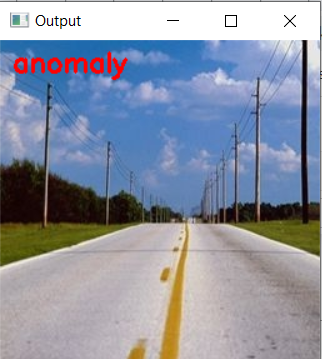

In [55]:
image = cv2.imread('forest_test.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hist = cv2.calcHist([hsv], [0, 1, 2], None, (3,3,3),[0, 180, 0, 256, 0, 256])
hist = cv2.normalize(hist, hist).flatten()
preds = model.predict([hist])
label = "anomaly" if preds == -1 else "normal"
print(label)

normal


In [56]:
color = (0, 0, 255) if preds == -1 else (0, 255, 0)

# draw the predicted label text on the original image
cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX,0.7, color, 2)

# display the image
cv2.imshow("Output", image)
cv2.waitKey(0)

-1

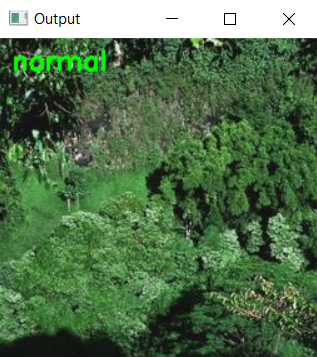